In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import celltrip

os.environ['AWS_PROFILE'] = 'waisman-admin'
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='dark', palette='colorblind')

# Running the Model

In [ ]:
# Read data files
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad',
    's3://nkalafut-celltrip/MERFISH_Bench/spatial.h5ad')
# Generate or load preprocessing
# TODO: Save and load mask
preprocessing = celltrip.utility.processing.Preprocessing(num_nodes=1_500, seed=42)
preprocessing.load('s3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250723.pre')
# Subset and preprocess the data
samples = adatas[0].obs.index  # Use partition cols here to select data
m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')
policy.load_checkpoint('s3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250723-0800.weights')

In [ ]:
# Run policy to convergence, and get pinning function
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1][:, :env.dim].cpu()
target_state = env.modalities[env.target_modalities[0]].cpu()
pinning_function, pinning_matrix = celltrip.utility.general.generate_pinning_function(
    steady_state, target_state)

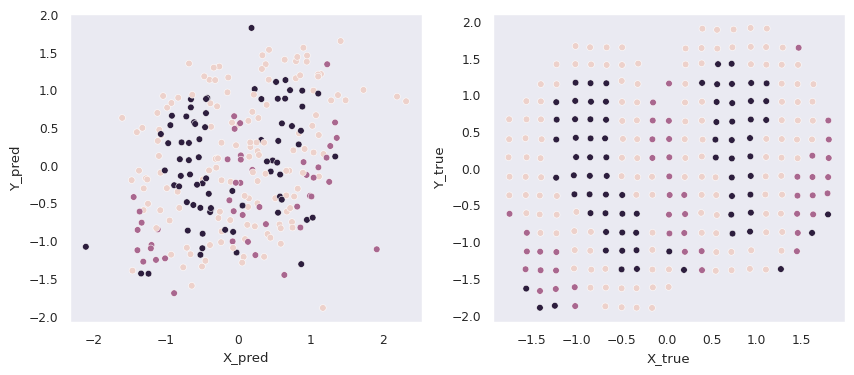

In [ ]:
# Plot imputed vs actual
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = pinning_function(steady_state)
df[['X_true', 'Y_true']] = target_state
df['Type'] = adatas[0].obs['pattern_gp_label']  # HMRF_k3_b.40
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_true', y='Y_true', hue='Type', legend=False, ax=axs[1])
fig.show()

# Running out-of-scope data

In [ ]:
# Load the second dataset
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad')
# Subset and preprocess the data
samples = adatas[0].obs.index  # Use partition cols here to select data
m1, = preprocessing.transform([ad[samples].X for ad in adatas])
# Initialize new environment
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, dim=8).eval().to('cuda')

In [ ]:
# Run policy to convergence
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1][:, :env.dim].cpu()

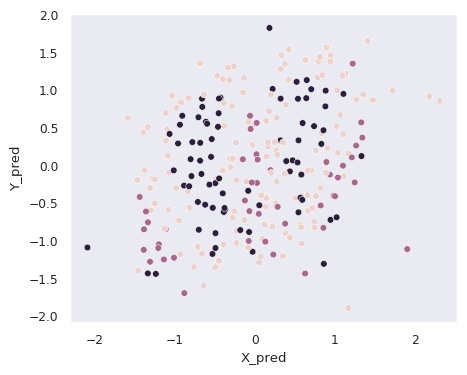

In [ ]:
# Plot imputed
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = pinning_function(steady_state)
df['Type'] = adatas[0].obs['pattern_gp_label']  # HMRF_k3_b.40
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', legend=False, ax=ax)
fig.show()